In [1]:
import os, warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import cv2, glob
from random import shuffle, randint
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Activation, Conv2DTranspose, Conv2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

Using TensorFlow backend.


In [3]:
image_files = glob.glob('../input/data/data/*.png')
shuffle(image_files)

In [4]:
x = []
for file in tqdm(image_files):
    image = cv2.imread(file)
    image = image / 127.5
    image = image - 1
    x.append(image)
x = np.array(x)
x.shape

100%|██████████| 21551/21551 [00:47<00:00, 453.27it/s]


(21551, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

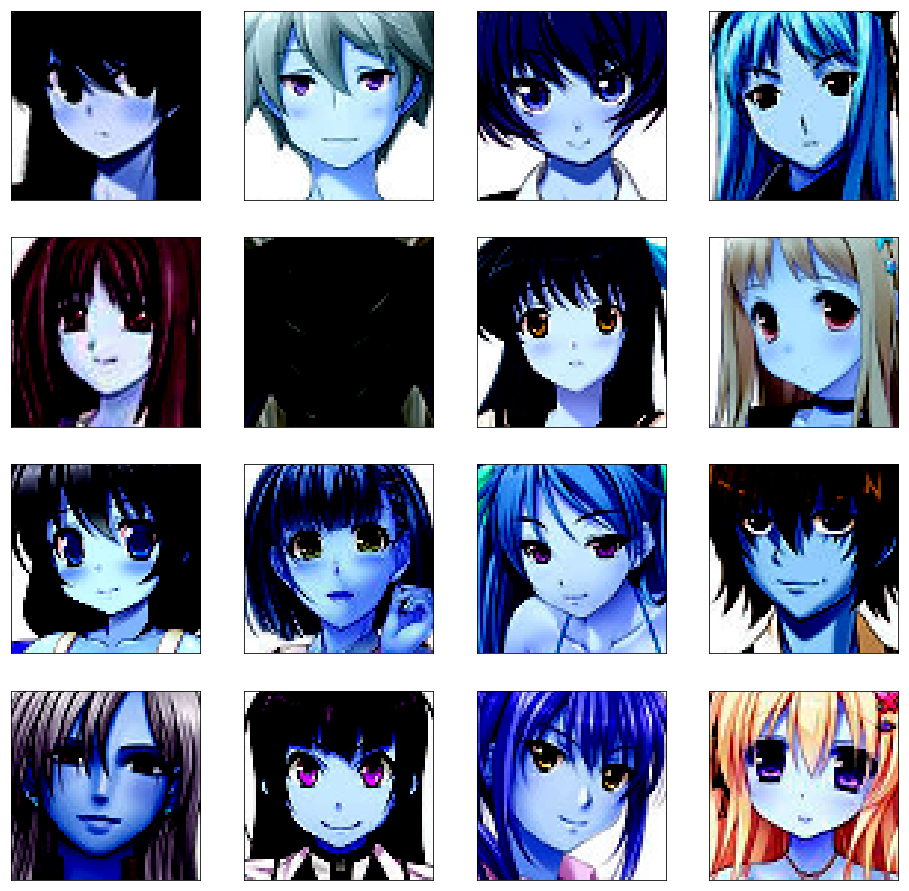

In [5]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 10000)
    ax.imshow(x[index], cmap = 'gray')
plt.show()

In [6]:
def build_discriminator(image_shape, learning_rate, beta_1):
    discriminator = Sequential([
        Conv2D(
            filters = 64,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform',
            input_shape = (image_shape)
        ),
        LeakyReLU(0.2),
        
        Conv2D(
            filters = 128,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform',
        ),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Conv2D(
            filters = 256,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform',
        ),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Conv2D(
            filters = 512,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform',
        ),
        BatchNormalization(momentum = 0.5),
        LeakyReLU(0.2),
        
        Flatten(),
        Dense(1),
        Activation('sigmoid')
    ], name = 'Discriminator')
    
    discriminator.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(
            lr = learning_rate,
            beta_1 = beta_1
        ),
        metrics = None
    )
    
    return discriminator

In [7]:
def build_generator(input_shape, learning_rate, beta_1):
    generator = Sequential([
        Dense(
            input_shape,
            kernel_initializer = 'glorot_uniform',
            input_shape = (1, 1, 100)
        ),
        Reshape(target_shape = (4, 4, 512)),
        BatchNormalization(momentum = 0.5),
        Activation('relu'),
        
        Conv2DTranspose(
            filters = 256,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform'
        ),
        BatchNormalization(momentum = 0.5),
        Activation('relu'),
        
        Conv2DTranspose(
            filters = 128,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform'
        ),
        BatchNormalization(momentum = 0.5),
        Activation('relu'),
        
        Conv2DTranspose(
            filters = 64,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform'
        ),
        BatchNormalization(momentum = 0.5),
        Activation('relu'),
        
        Conv2DTranspose(
            filters = 3,
            kernel_size = (5, 5),
            strides = (2, 2),
            padding = 'same',
            data_format = 'channels_last',
            kernel_initializer = 'glorot_uniform'
        ),
        Activation('tanh'),
    ], name = 'Generator')
    
    generator.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(
            lr = learning_rate,
            beta_1 = beta_1
        ),
        metrics = None
    )
    
    return generator

In [8]:
def build_gan(generator, discriminator, learning_rate, beta_1):
    gan = Sequential([
        generator,
        discriminator
    ], name = 'GAN')
    gan.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(
            lr = learning_rate,
            beta_1 = beta_1
        ),
        metrics = None
    )
    return gan

In [9]:
discriminator = build_discriminator((64, 64, 3), 0.0002, 0.5)
discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batc

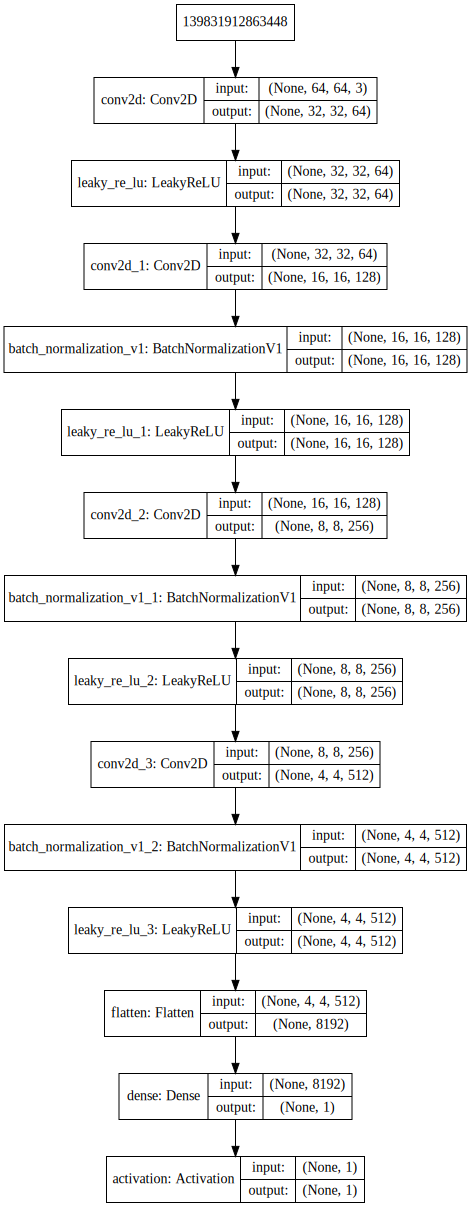

In [10]:
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [11]:
generator = build_generator(np.prod(discriminator.layers[-4].output_shape[1:]), 0.00015, 0.5)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 1, 8192)        827392    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)         0         
__________

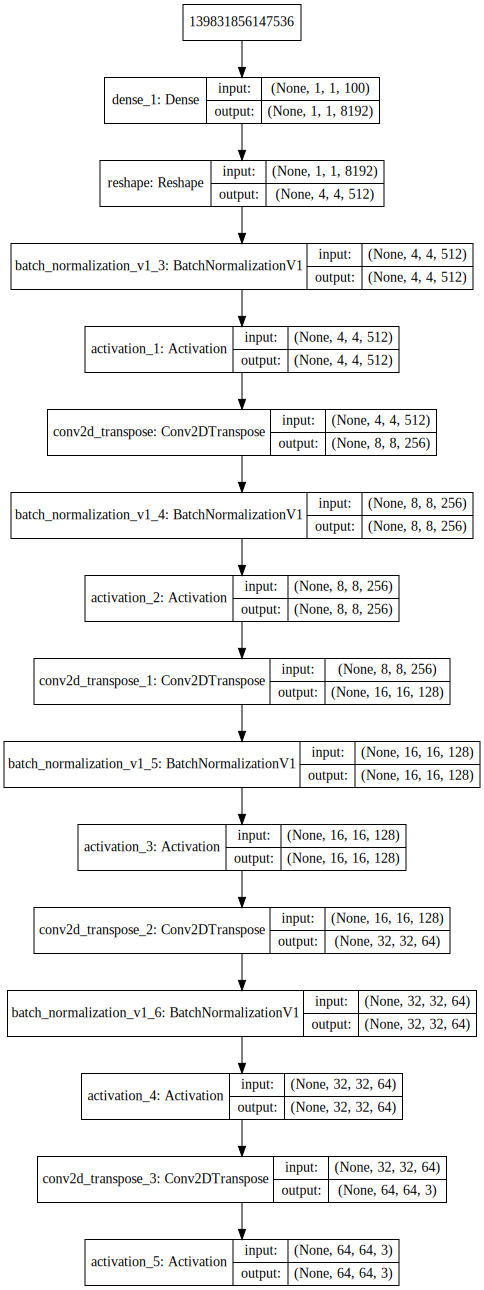

In [12]:
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [13]:
discriminator.trainable = False
gan = build_gan(generator, discriminator, 0.00015, 0.5)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 64, 64, 3)         5137283   
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 4318337   
Total params: 9,455,620
Trainable params: 5,135,363
Non-trainable params: 4,320,257
_________________________________________________________________


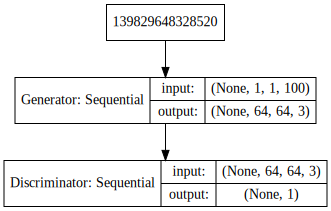

In [14]:
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [15]:
EPOCHS = 15000
BATCH_SIZE = 32

In [16]:
def plot_images(nrows, ncols, figsize, generator):
    noise = np.random.normal(0, 1, size = (BATCH_SIZE * 2, ) + (1, 1, 100))
    prediction = generator.predict(noise)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.setp(axes.flat, xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        index = randint(0, 63)
        ax.imshow(cv2.cvtColor(prediction[index], cv2.COLOR_BGR2RGB), cmap = 'gray')
    plt.show()

  0%|          | 0/15000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


  7%|▋         | 999/15000 [01:14<15:53, 14.69it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..

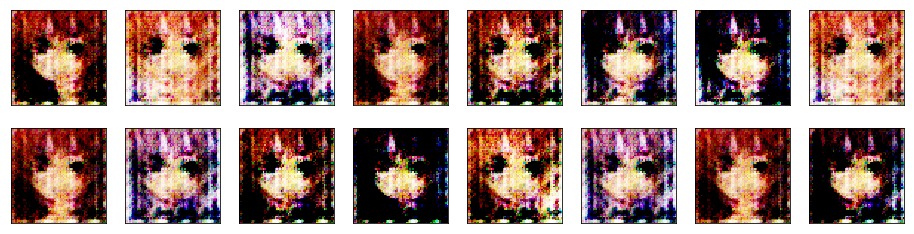

 13%|█▎        | 1999/15000 [02:23<14:45, 14.69it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

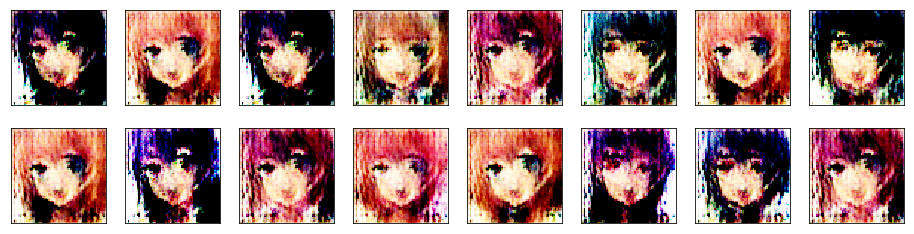

 20%|█▉        | 2999/15000 [03:32<13:34, 14.74it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

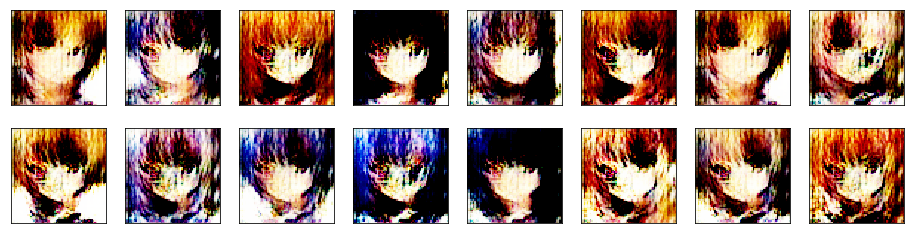

 27%|██▋       | 3999/15000 [04:42<12:26, 14.73it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

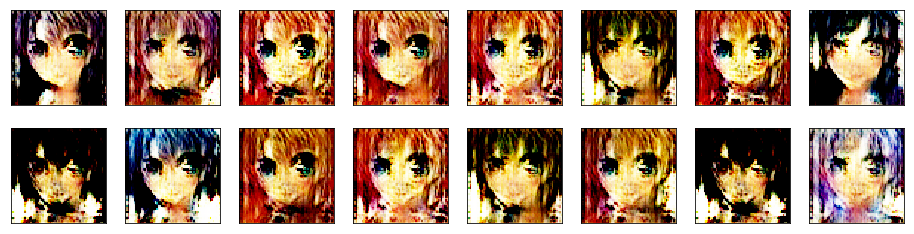

 33%|███▎      | 4999/15000 [05:50<11:27, 14.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

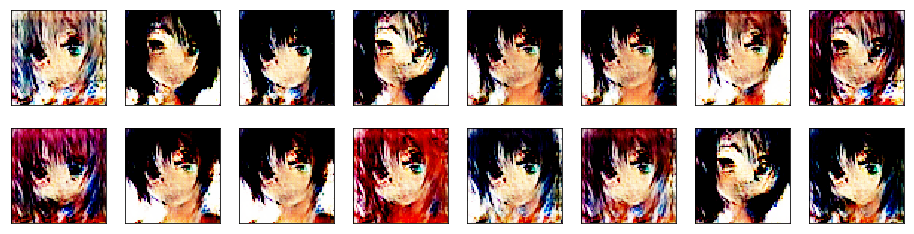

 40%|███▉      | 5999/15000 [06:59<10:13, 14.68it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

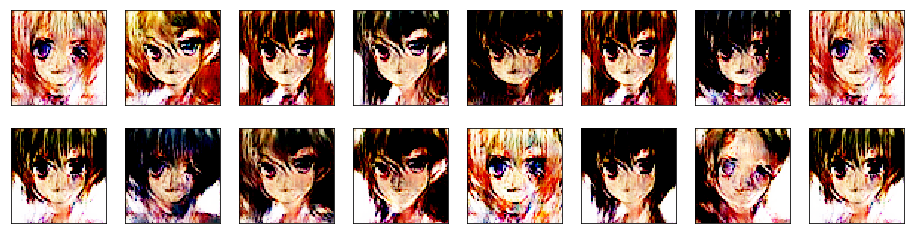

 47%|████▋     | 6999/15000 [08:08<08:59, 14.82it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

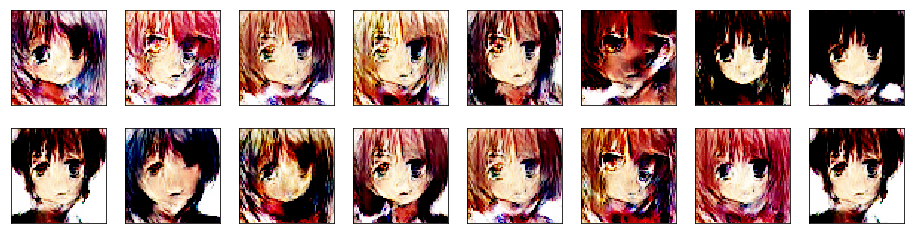

 53%|█████▎    | 7999/15000 [09:17<07:52, 14.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

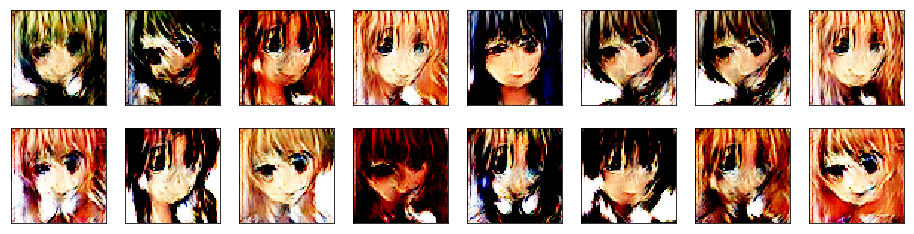

 60%|█████▉    | 8999/15000 [10:26<06:47, 14.74it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

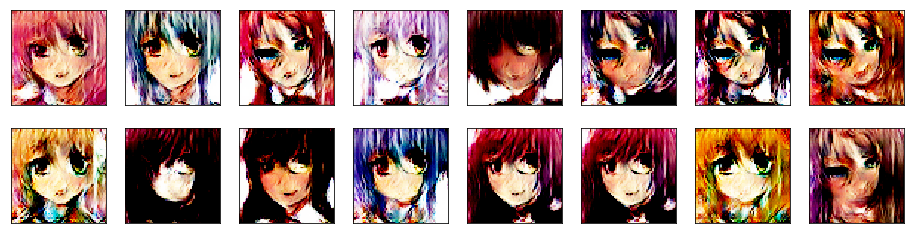

 67%|██████▋   | 9999/15000 [11:35<05:41, 14.66it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0.

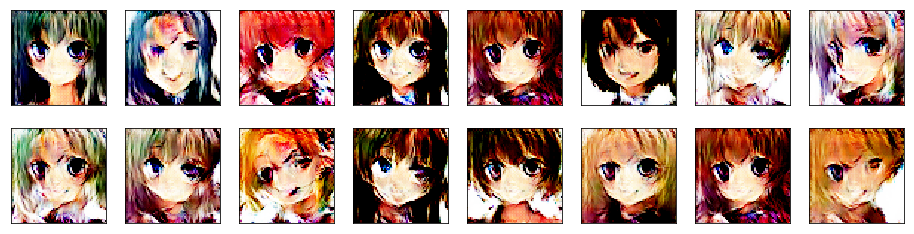

 73%|███████▎  | 10999/15000 [12:44<04:32, 14.69it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0

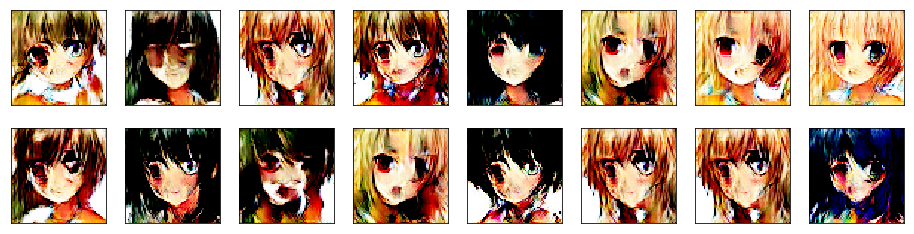

 80%|███████▉  | 11999/15000 [13:53<03:29, 14.34it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0

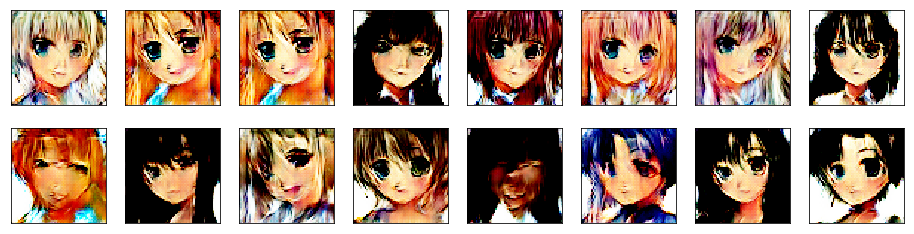

 87%|████████▋ | 12999/15000 [15:02<02:16, 14.64it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0

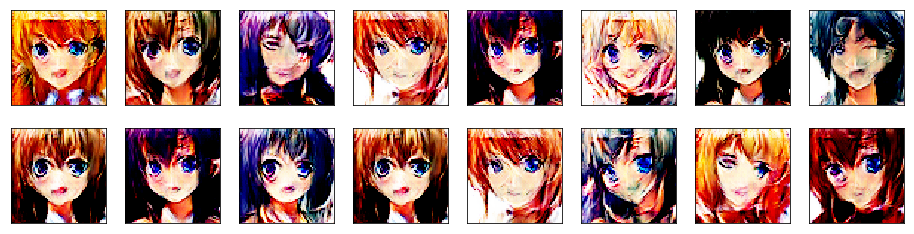

 93%|█████████▎| 13999/15000 [16:11<01:07, 14.74it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0

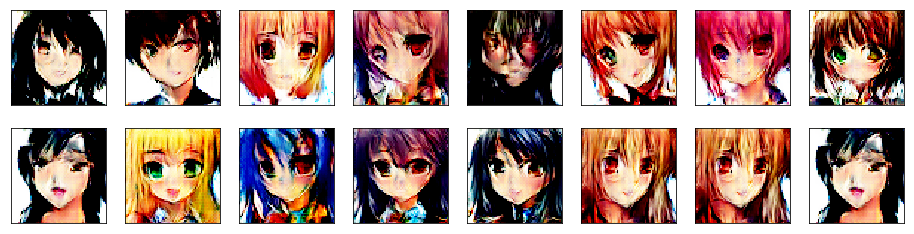

 96%|█████████▌| 14433/15000 [16:41<00:39, 14.31it/s]

In [17]:
discriminator_loss_history, generator_loss_history = [], []

for epoch in tqdm(range(1, EPOCHS + 1)):
    
    # Select a random batch of images from training data
    index = np.random.randint(0, x.shape[0], BATCH_SIZE)
    batch_images = x[index]
    
    # Adversarial Noise
    noise = np.random.normal(0, 1, size = (BATCH_SIZE, ) + (1, 1, 100))
    
    # Fenerate Fake Images
    generated_images = generator.predict(noise)
    
    # Adding noise to the labels before passing to the discriminator
    real_y = (np.ones(BATCH_SIZE) -  np.random.random_sample(BATCH_SIZE) * 0.2)
    fake_y = np.random.random_sample(BATCH_SIZE) * 0.2
    
    # Training the discriminator
    discriminator.trainable = True
    discriminator_loss = discriminator.train_on_batch(batch_images, real_y)
    discriminator_loss += discriminator.train_on_batch(generated_images, fake_y)
    discriminator.trainable = False
    
    # Adversarial Noise
    noise = np.random.normal(0, 1, size = (BATCH_SIZE * 2,) + (1, 1, 100))
    
    # We try to mislead the discriminator by giving the opposite labels
    fake_y = (np.ones(BATCH_SIZE * 2) - np.random.random_sample(BATCH_SIZE * 2) * 0.2)
    
    # Training the Generator
    generator_loss = gan.train_on_batch(noise, fake_y)
    
    if epoch % 100 == 0:
        discriminator_loss_history.append(discriminator_loss)
        generator_loss_history.append(generator_loss)
        if epoch % 1000 == 0:
            plot_images(2, 8, (16, 4), generator)

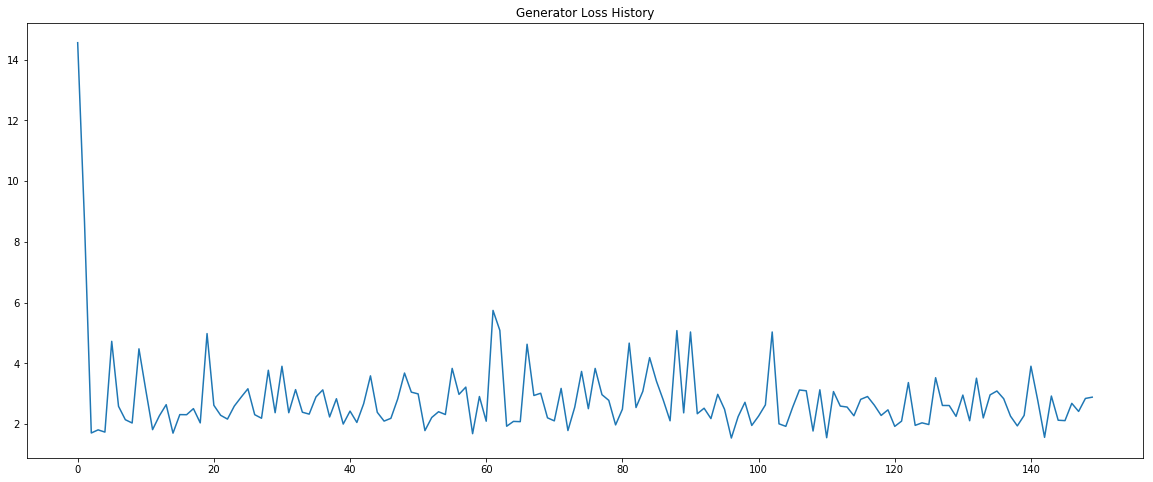

In [18]:
plt.figure(figsize = (20, 8))
plt.plot(generator_loss_history)
plt.title('Generator Loss History')
plt.show()

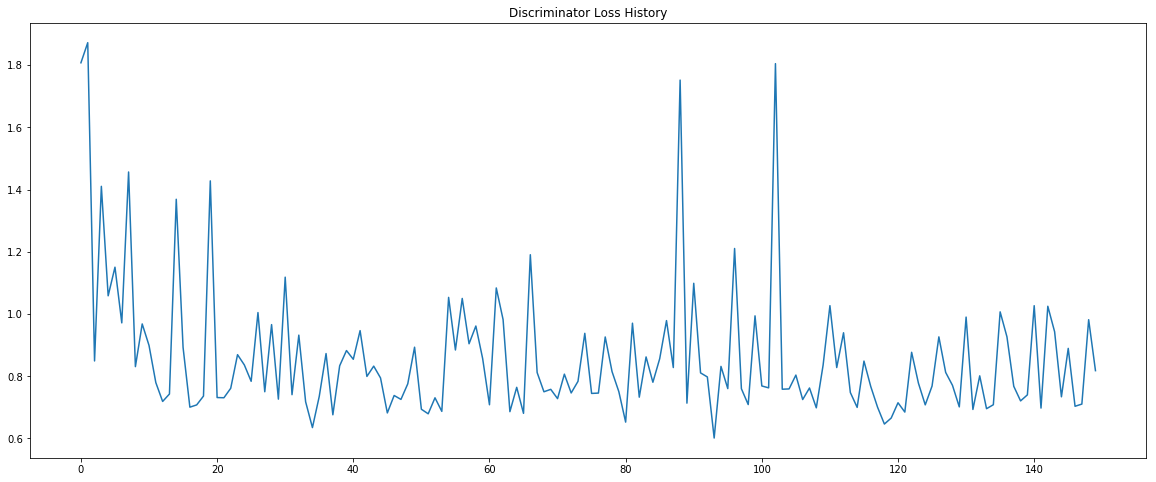

In [19]:
plt.figure(figsize = (20, 8))
plt.plot(discriminator_loss_history)
plt.title('Discriminator Loss History')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

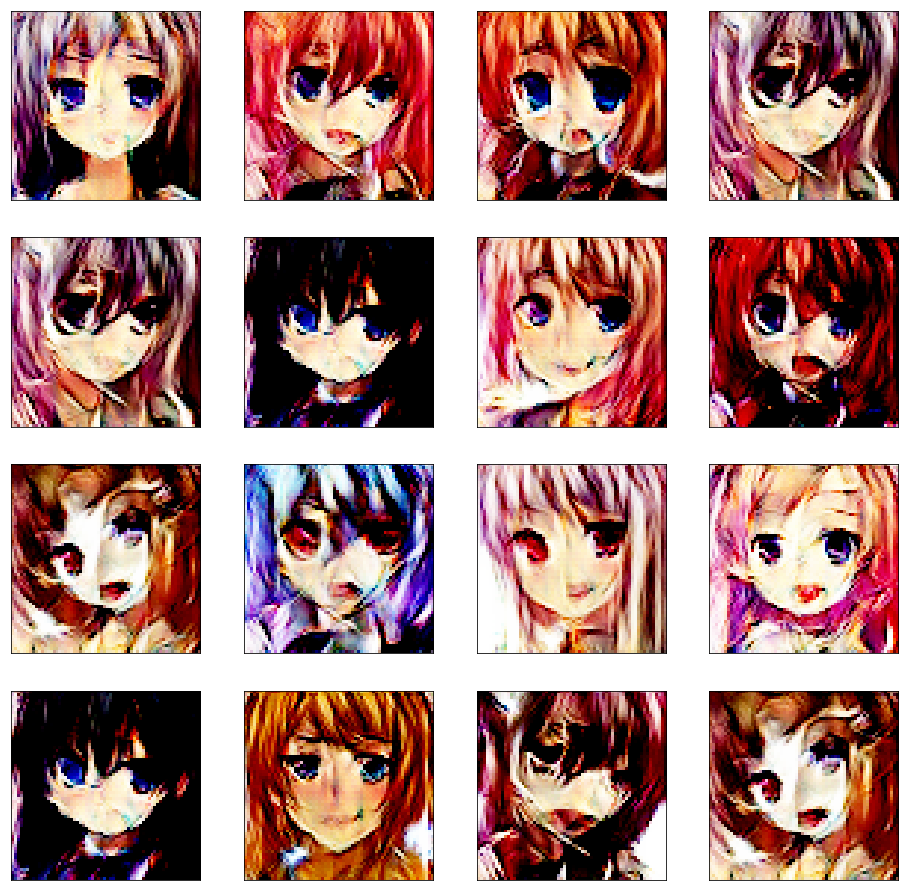

In [20]:
plot_images(4, 4, (16, 16), generator)

In [21]:
generator.save('./generator.h5')